In [1]:
import pandas as pd
import numpy as np
import os
import json 
import sys
from typing import Dict, Tuple, Any, Optional, List
sys.path.append('..')
import time
from src.utils import load_data

c:\Users\1\anaconda3\envs\rag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset with human annotations
df_asqa = load_data('../data/asqa/asqa_with_human_343.json')
df_wikieval = load_data('../data/wikieval/all.json')
df_antique = load_data('../data/antique/all.json')

In [25]:
df_antique = df_antique[df_antique['BERT Score'] != 0]

## idf

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tf_idf(documents: List[str]) -> Tuple[Dict[str, float], Dict[str, float]]:
    """
    计算多个文档中的TF和IDF

    参数:
    documents (List[str]): 文档列表

    返回:
    Tuple[Dict[str, float], Dict[str, float]]: 包含TF和IDF的字典
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # 获取词汇表
    feature_names = vectorizer.get_feature_names_out()
    
    # 计算TF
    tf = tfidf_matrix.sum(axis=0).A1
    tf_dict = dict(zip(feature_names, tf))
    
    # 计算IDF
    idf = vectorizer.idf_
    idf_dict = dict(zip(feature_names, idf))
    
    return tf_dict, idf_dict

# 示例文档
documents = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

tf_dict, idf_dict = compute_tf_idf(documents)
print("TF:", tf_dict)
print("IDF:", idf_dict)

TF: {'and': 0.511848512707169, 'document': 1.6272063691435348, 'first': 1.1605716473688719, 'is': 1.3163629435055506, 'one': 0.511848512707169, 'second': 0.5386476208856763, 'the': 1.3163629435055506, 'third': 0.511848512707169, 'this': 1.3163629435055506}
IDF: {'and': 1.916290731874155, 'document': 1.2231435513142097, 'first': 1.5108256237659907, 'is': 1.0, 'one': 1.916290731874155, 'second': 1.916290731874155, 'the': 1.0, 'third': 1.916290731874155, 'this': 1.0}


In [4]:
doc_antique = df_antique['query'].unique().tolist()+df_antique['doc'].unique().tolist()+df_antique['answer'].tolist()

In [5]:
doc_asqa = df_asqa['ambiguous_question'].unique().tolist()+df_asqa['response'].tolist()+np.unique(np.array(df_asqa['long_answers'].tolist()).flatten()).tolist()

In [6]:
doc_wikieval = df_wikieval['question'].unique().tolist()+df_wikieval['answer'].tolist()+df_wikieval['context'].unique().tolist()+df_wikieval['gt_answer'].unique().tolist()

In [7]:
docs = doc_antique+doc_asqa+doc_wikieval

In [8]:
tf_dict, idf_dict = compute_tf_idf(docs)

In [15]:
def calculate_max_avg_idf(sentence: str, idf_dict: Dict[str, float]) -> Tuple[float, float]:
    """
    计算一句话的最大IDF和平均IDF

    参数:
    sentence (str): 输入句子
    idf_dict (Dict[str, float]): IDF字典

    返回:
    Tuple[float, float]: 最大IDF和平均IDF
    """
    words = sentence.split()
    idf_values = [idf_dict.get(word, 0.0) for word in words]
    
    if not idf_values:
        return 0.0, 0.0
    
    max_idf = max(idf_values)
    avg_idf = sum(idf_values) / len(idf_values)
    
    return max_idf, avg_idf

# 示例句子
sentence = "This is a sample sentence to calculate IDF values."
max_idf, avg_idf = calculate_max_avg_idf(sentence, idf_dict)
print("Max IDF:", max_idf)
print("Avg IDF:", avg_idf)

Max IDF: 8.234537865055833
Avg IDF: 2.8018126940133734


In [16]:
df_asqa['max_idf'] = df_asqa['response'].apply(lambda x: calculate_max_avg_idf(x, idf_dict)[0])
df_asqa['avg_idf'] = df_asqa['response'].apply(lambda x: calculate_max_avg_idf(x, idf_dict)[1])

df_antique['max_idf'] = df_antique['answer'].apply(lambda x: calculate_max_avg_idf(x, idf_dict)[0])
df_antique['avg_idf'] = df_antique['answer'].apply(lambda x: calculate_max_avg_idf(x, idf_dict)[1])

df_wikieval['max_idf'] = df_wikieval['answer'].apply(lambda x: calculate_max_avg_idf(x, idf_dict)[0])
df_wikieval['avg_idf'] = df_wikieval['answer'].apply(lambda x: calculate_max_avg_idf(x, idf_dict)[1])

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制散点图
def draw_kde_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str) -> None:
    """
    绘制双变量核密度估计图

    参数:
    df (pd.DataFrame): 数据框
    x_col (str): x轴列名
    y_col (str): y轴列名
    title (str): 图表标题
    """
    sns.kdeplot(x=df[x_col], y=df[y_col], fill=True)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.show()

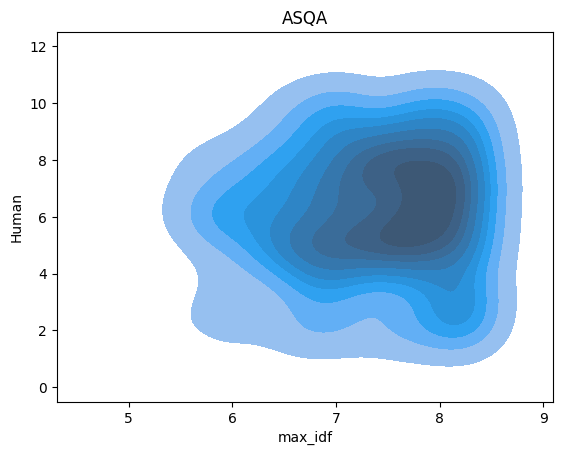

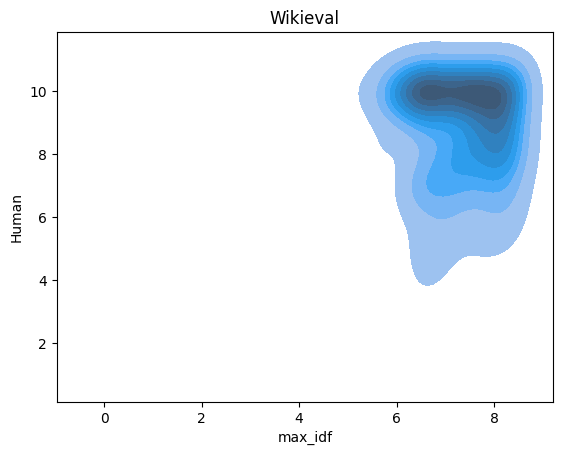

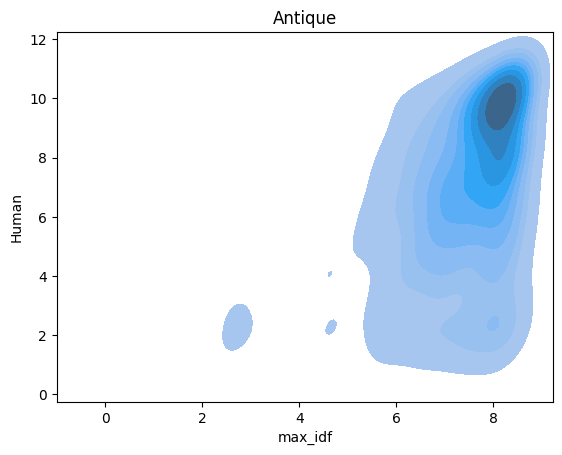

In [41]:
draw_kde_plot(df_asqa, 'max_idf', 'Human', 'ASQA')
draw_kde_plot(df_wikieval, 'max_idf', 'Human', 'Wikieval')
draw_kde_plot(df_antique, 'max_idf', 'Human', 'Antique')

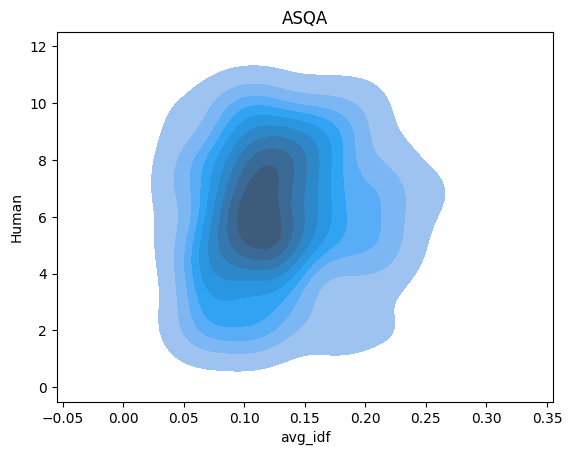

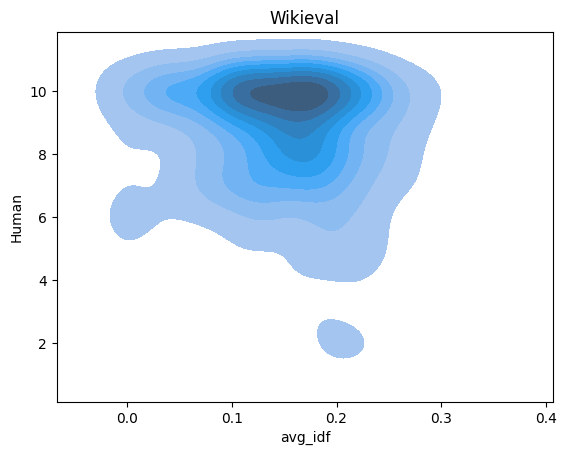

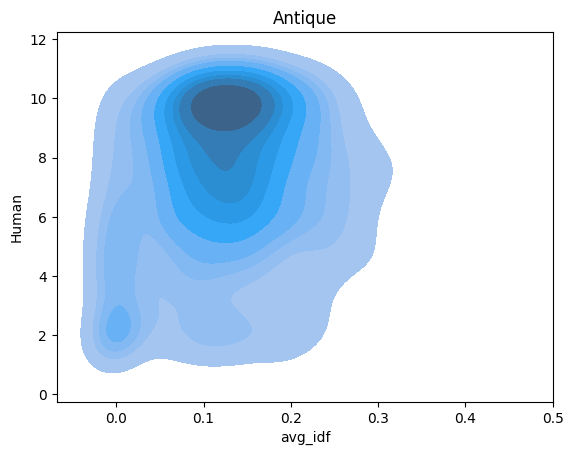

In [18]:
draw_kde_plot(df_asqa, 'avg_idf', 'Human', 'ASQA')
draw_kde_plot(df_wikieval, 'avg_idf', 'Human', 'Wikieval')
draw_kde_plot(df_antique, 'avg_idf', 'Human', 'Antique')

In [11]:
def draw_kde_plots(df,rows, cols,x, dataset, metrics):
    # Set up the figure with multiple subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    # fig.suptitle(f'Relationship between {x} and Different Metrics on {dataset}', fontsize=16)

    for idx, metric in enumerate(metrics):
        row = idx // cols
        col = idx % cols

        sns.kdeplot(data=df, x=x, y=metric, ax=axes[row, col], fill=True, cmap='Blues', alpha=0.7)
        # axes[row, col].set_title(f'{x} vs {metric}')
        axes[row, col].set_xlabel('Average IDF of answer')
        axes[row, col].set_ylabel(metric)
    # Remove empty subplots
    for idx in range(len(metrics), rows * cols):
        fig.delaxes(axes.flatten()[idx])
    plt.tight_layout()
    plt.show()

In [63]:
from src.consistency import calculate_correlation
for m in ['Human', 'Rouge L', 'BERT Score', 'Exact Match', 'Disambig F1', 'Answer Relevance', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0']:
    print(f"Correlation between max_idf and {m} on ASQA: {calculate_correlation(df_asqa['max_idf'], df_asqa[m])}")
    print(f"Correlation between avg_idf and {m} on ASQA: {calculate_correlation(df_asqa['avg_idf'], df_asqa[m])}")

Correlation between max_idf and Human on ASQA: 3.4016572248798975
Correlation between avg_idf and Human on ASQA: 6.748309772214727
Correlation between max_idf and Rouge L on ASQA: -15.767876286139277
Correlation between avg_idf and Rouge L on ASQA: -12.188177793380845
Correlation between max_idf and BERT Score on ASQA: -14.04012527636478
Correlation between avg_idf and BERT Score on ASQA: -3.891224263791895
Correlation between max_idf and Exact Match on ASQA: -8.429500057568074
Correlation between avg_idf and Exact Match on ASQA: -5.518564086770892
Correlation between max_idf and Disambig F1 on ASQA: 5.53053005070457
Correlation between avg_idf and Disambig F1 on ASQA: 7.4515164783523655
Correlation between max_idf and Answer Relevance on ASQA: -1.2962627255111532
Correlation between avg_idf and Answer Relevance on ASQA: 0.3650857090519369
Correlation between max_idf and GPT-4o Fine-grained on ASQA: 8.755325998325086
Correlation between avg_idf and GPT-4o Fine-grained on ASQA: 15.92677

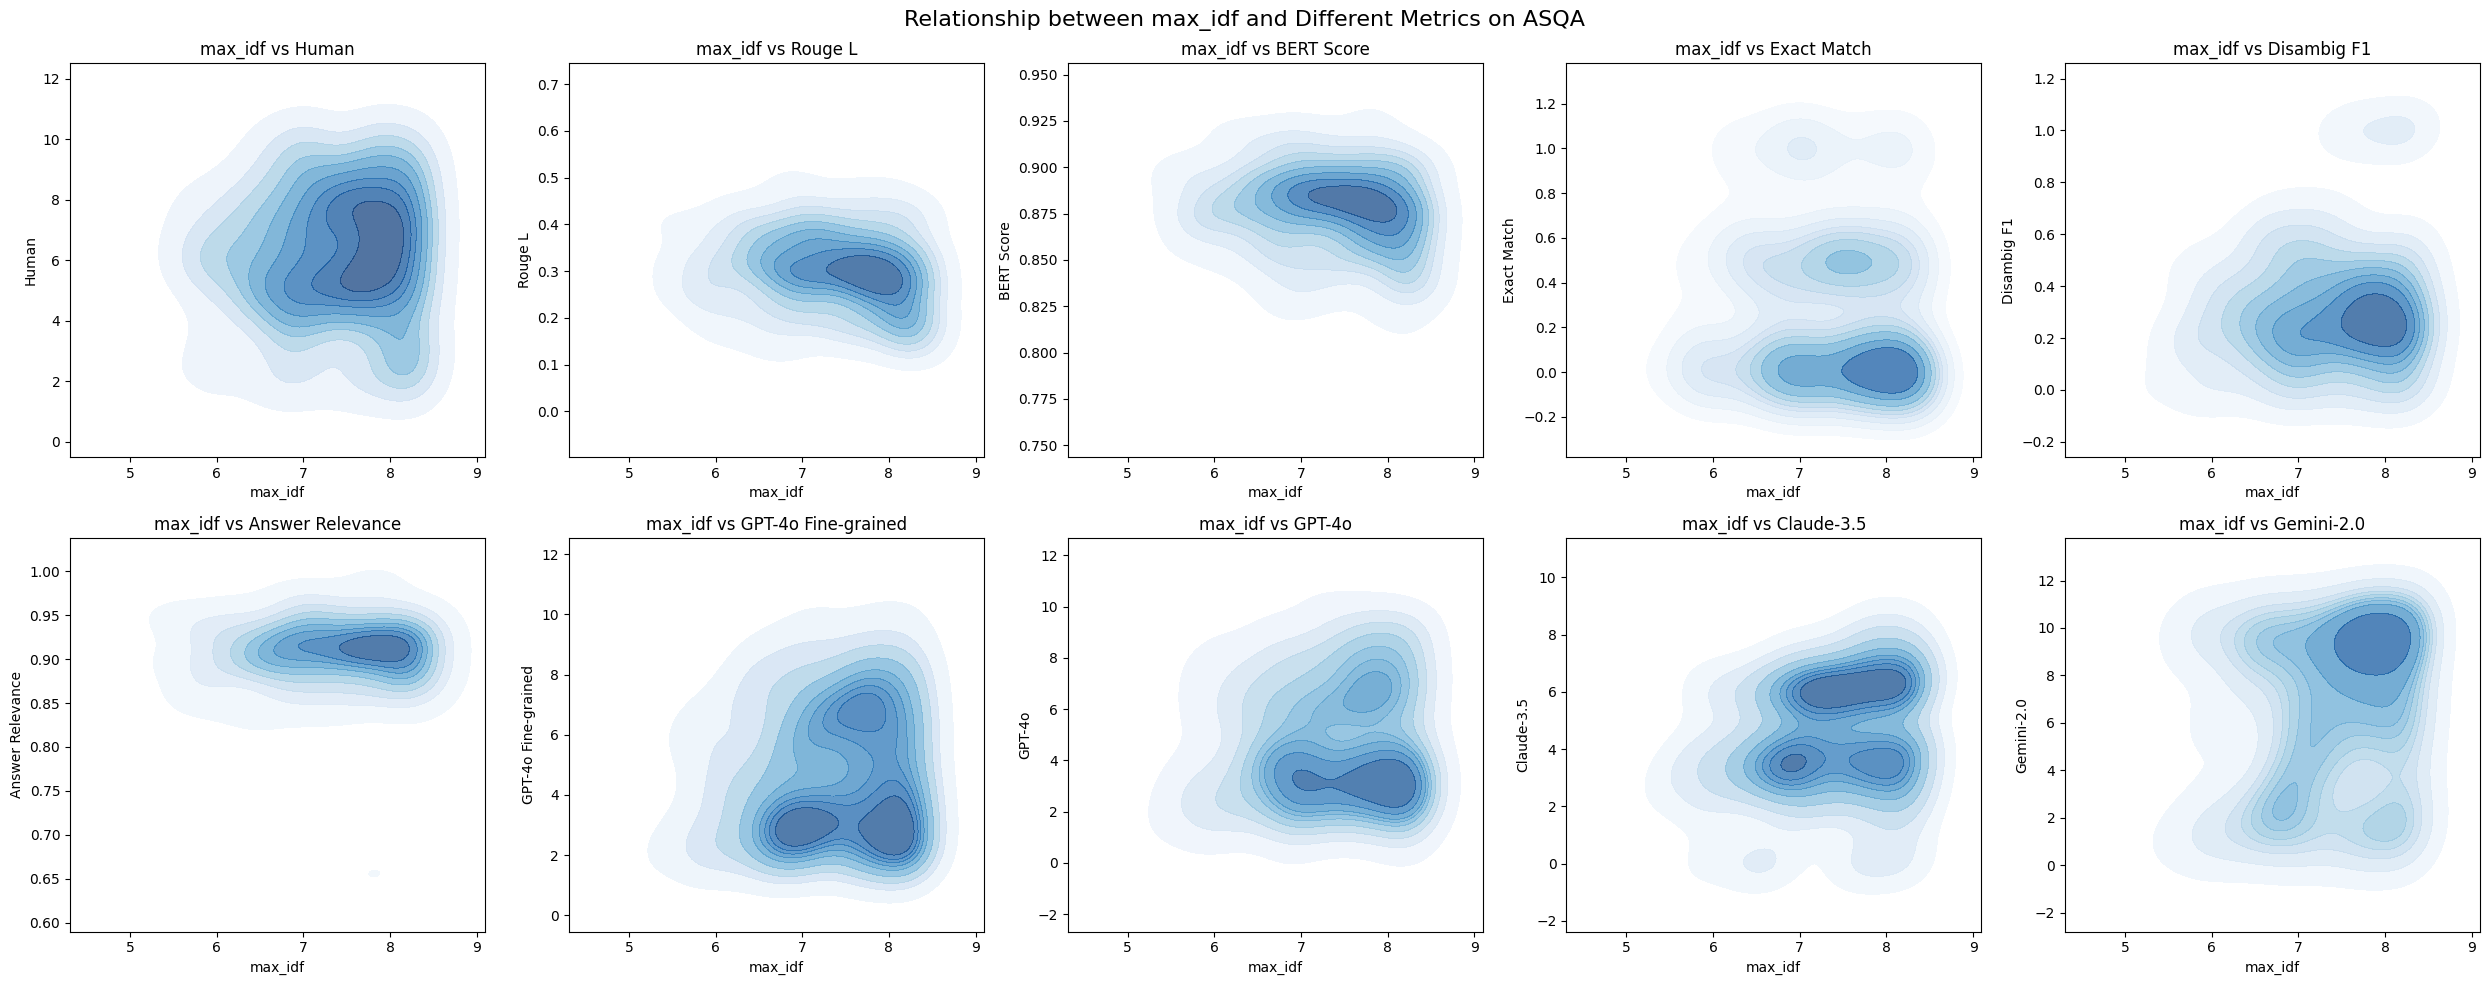

In [58]:
draw_kde_plots(df_asqa,2,5, 'max_idf', 'ASQA',['Human', 'Rouge L', 'BERT Score', 'Exact Match', 'Disambig F1', 'Answer Relevance', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0'])

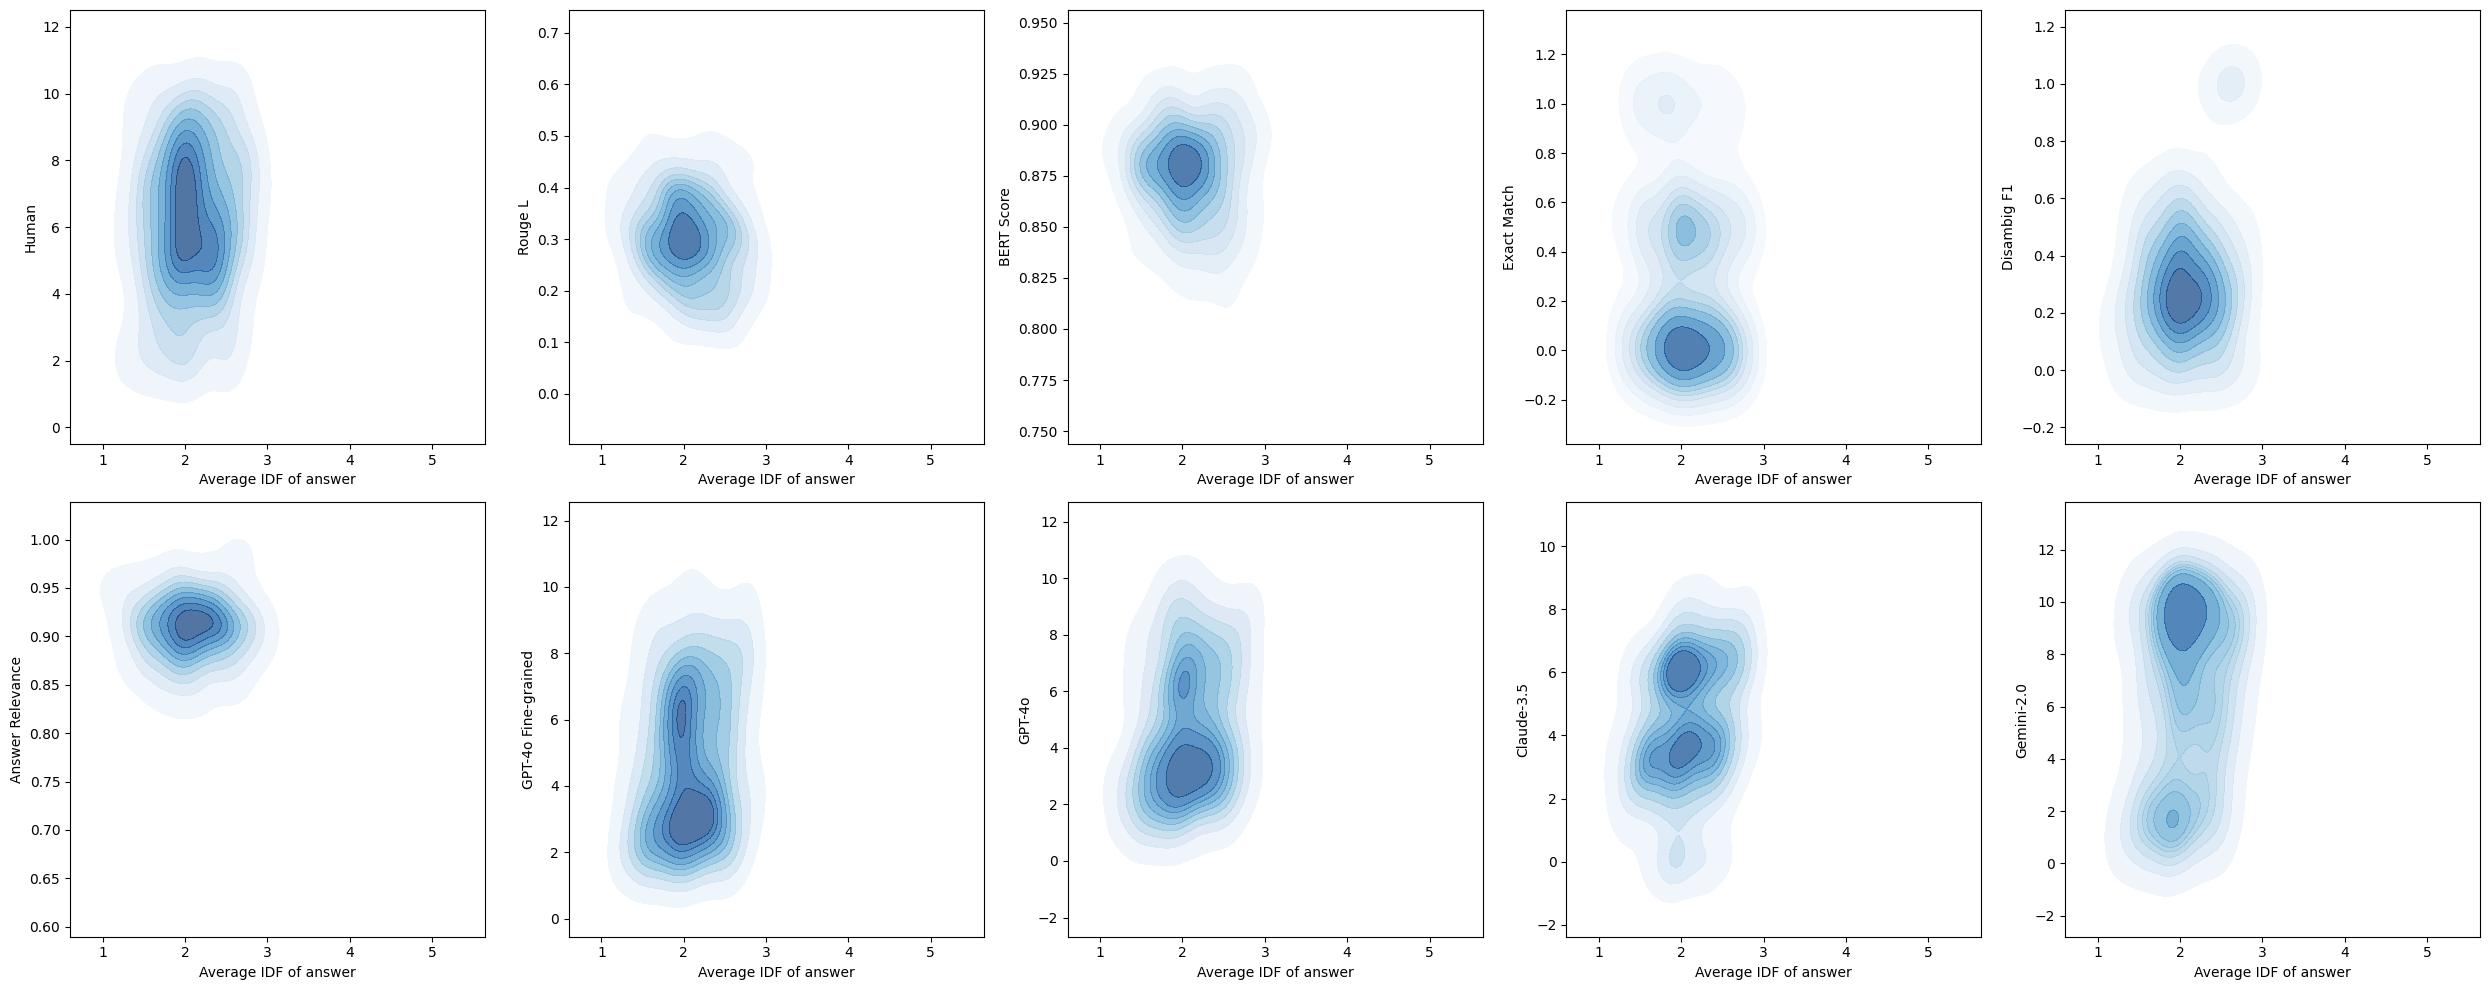

In [17]:
draw_kde_plots(df_asqa,2,5, 'avg_idf', 'ASQA',['Human', 'Rouge L', 'BERT Score', 'Exact Match', 'Disambig F1', 'Answer Relevance', 'GPT-4o Fine-grained', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0'])

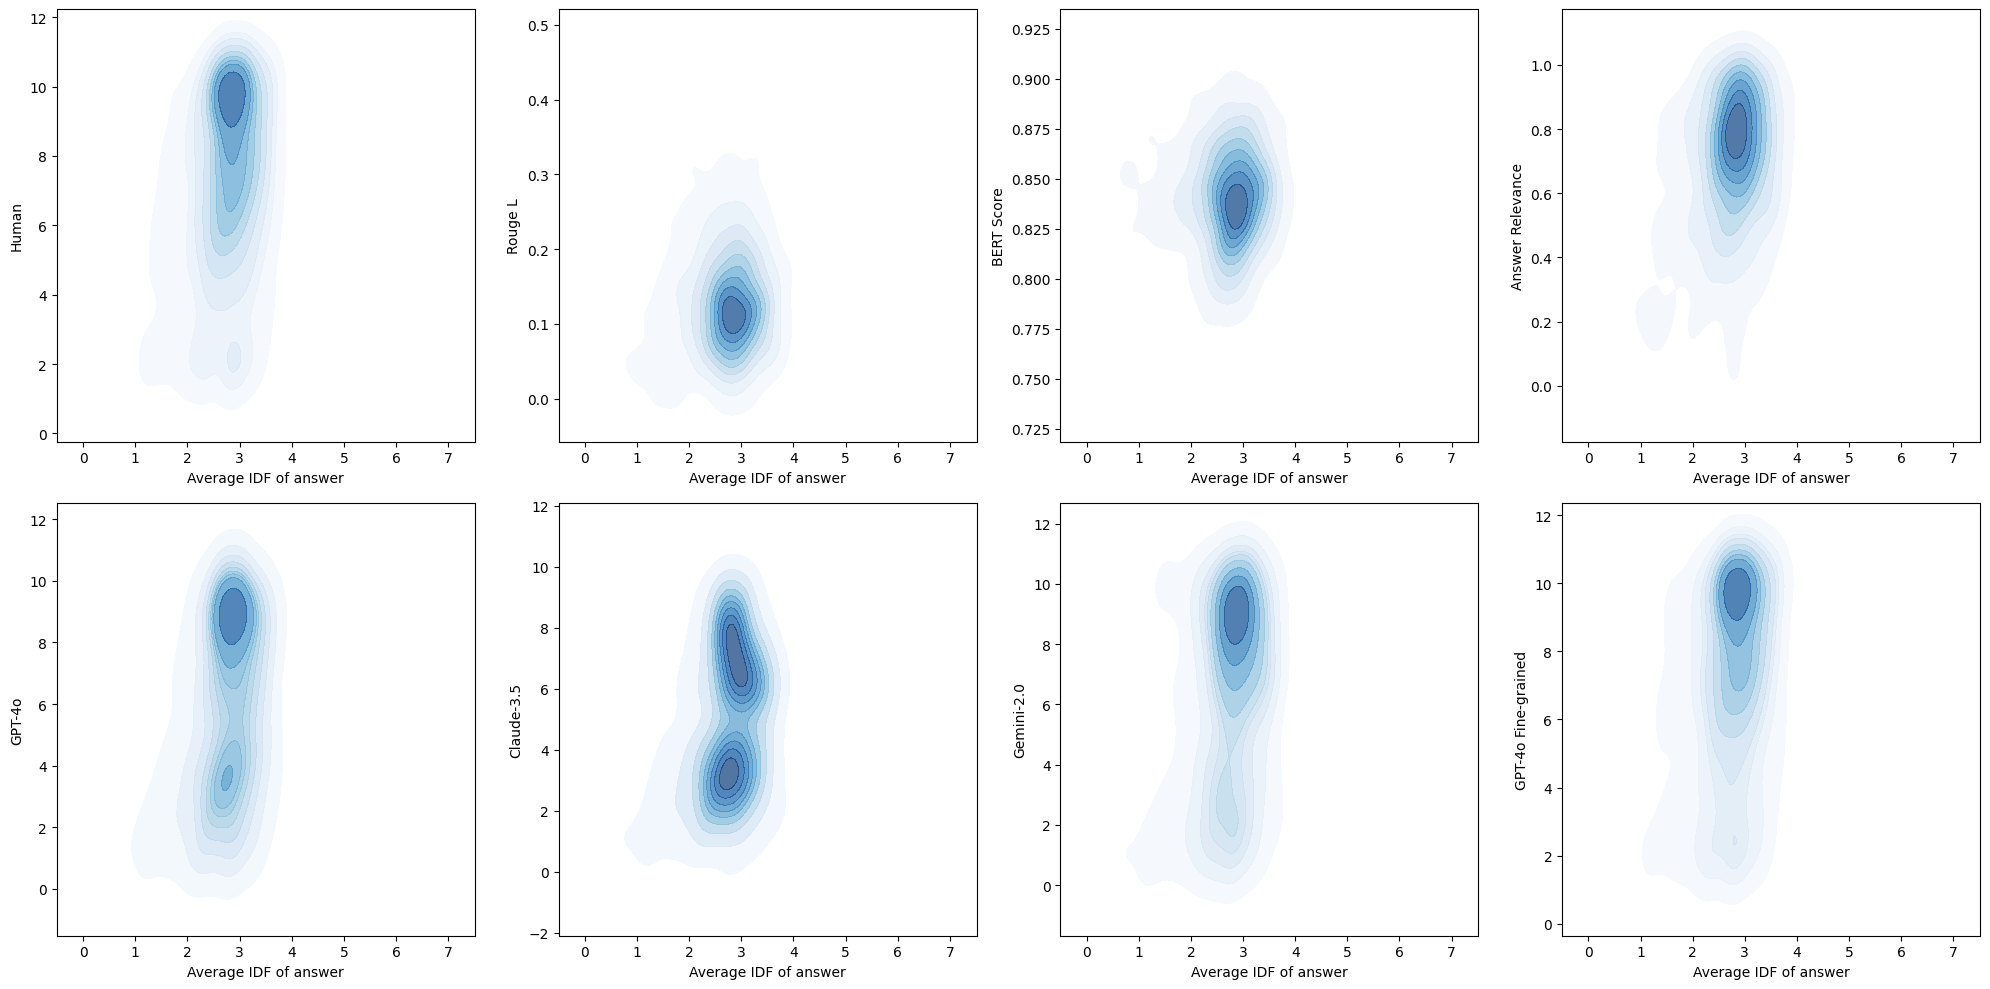

In [26]:
draw_kde_plots(df_antique,2,4, 'avg_idf', 'antique',['Human','Rouge L', 'BERT Score', 'Answer Relevance','GPT-4o', 'Claude-3.5','Gemini-2.0','GPT-4o Fine-grained'])

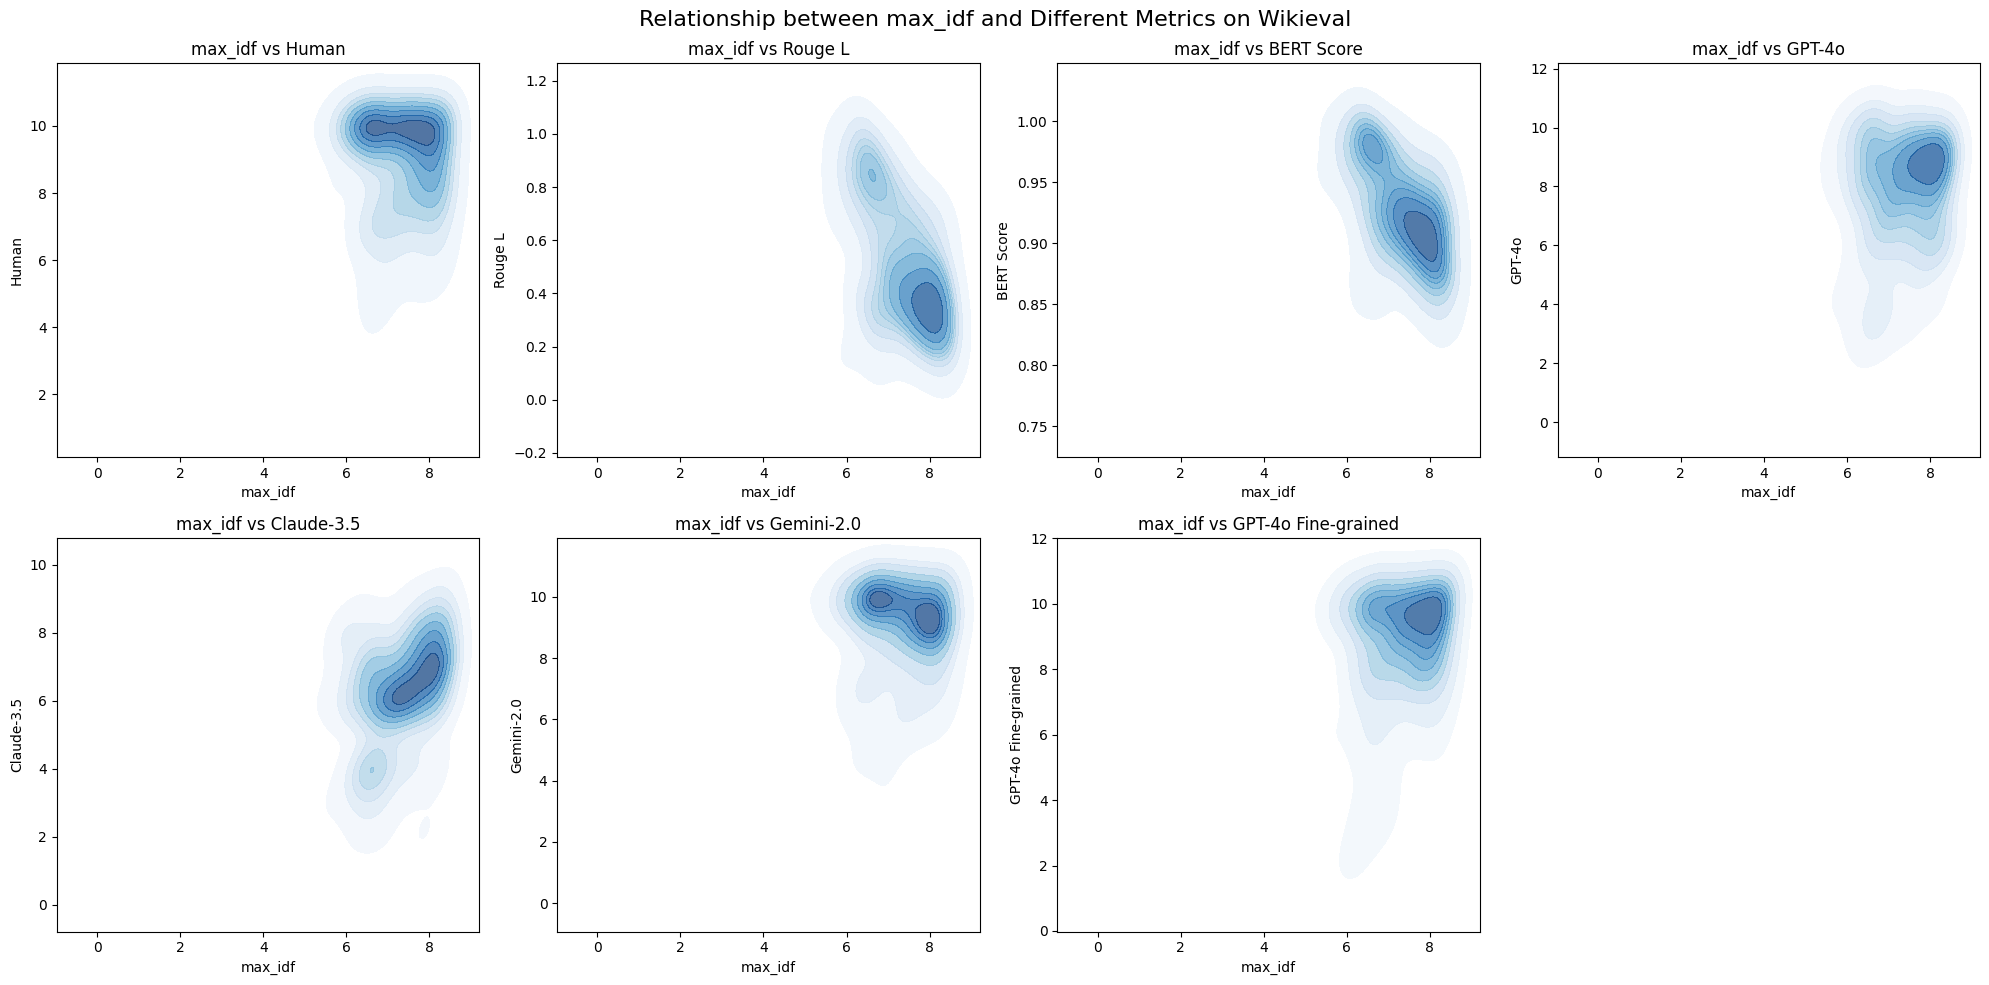

In [60]:
draw_kde_plots(df_wikieval,2,4, 'max_idf', 'Wikieval',['Human', 'Rouge L', 'BERT Score', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'GPT-4o Fine-grained'])

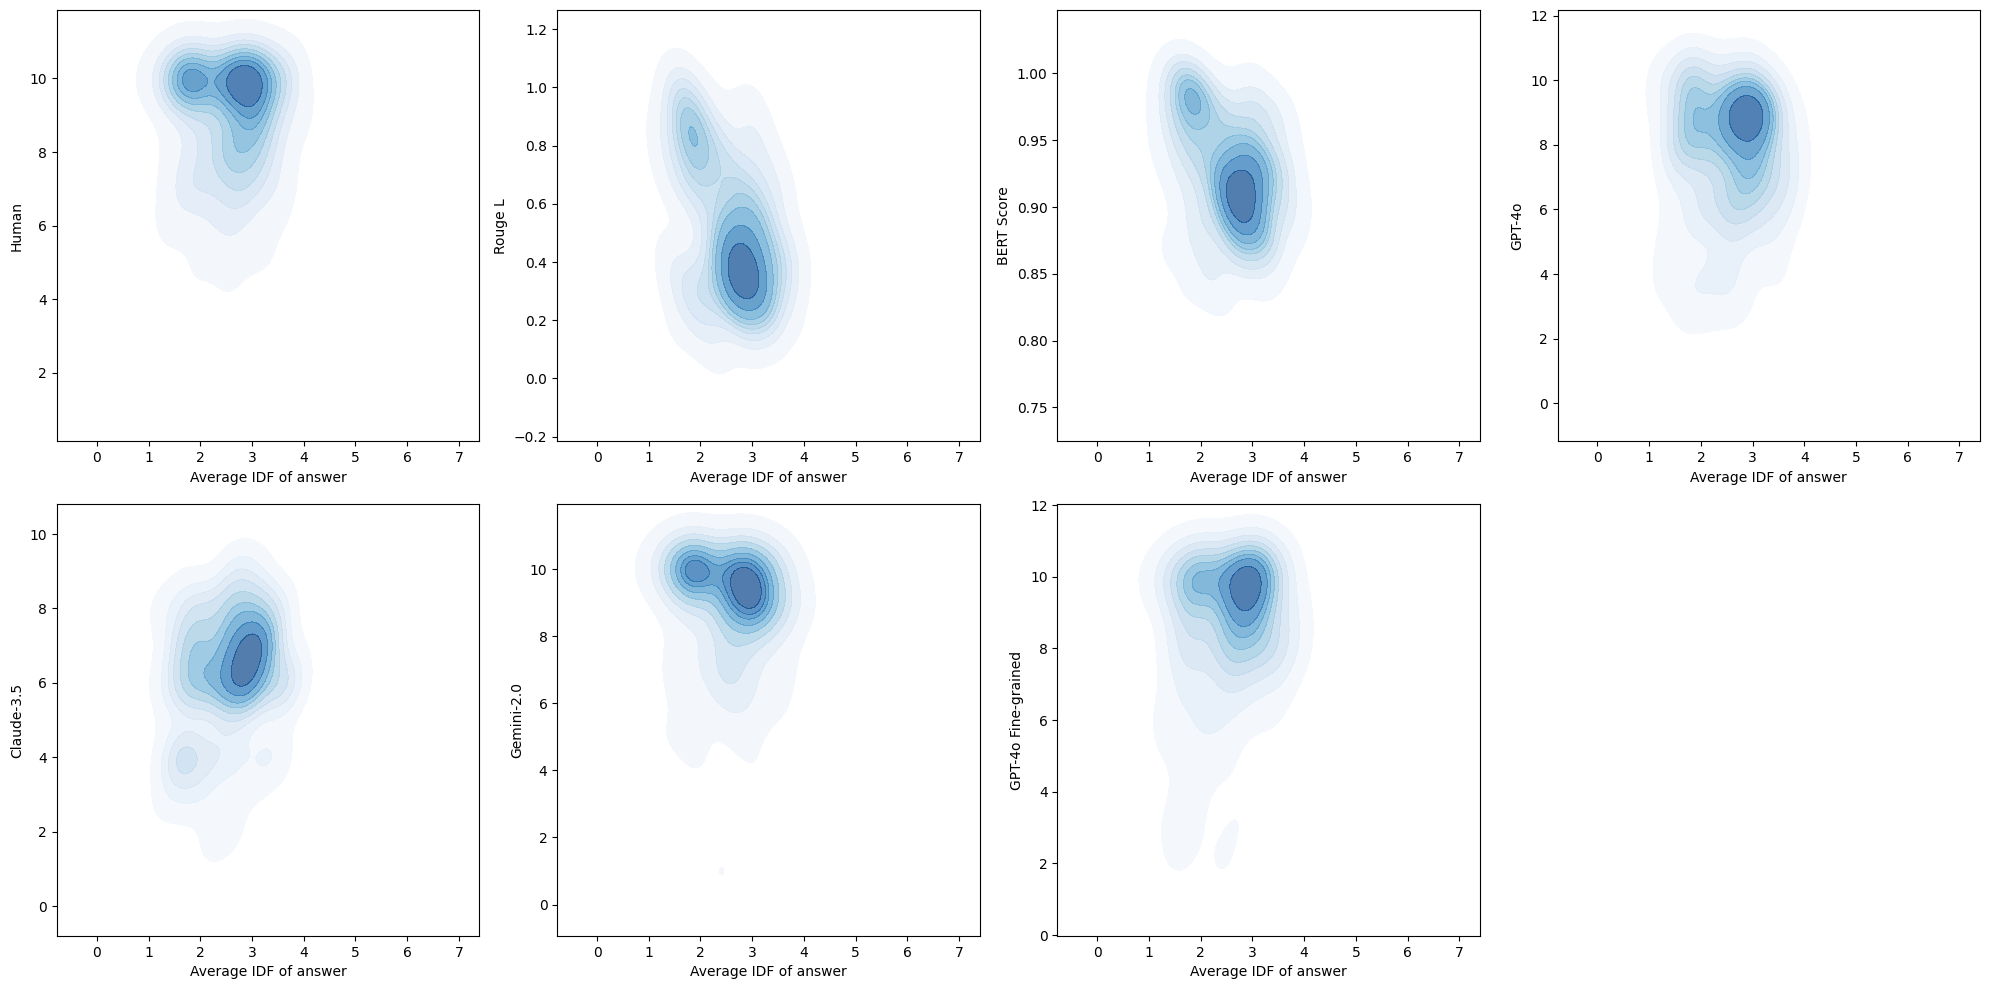

In [36]:
draw_kde_plots(df_wikieval,2,4, 'avg_idf', 'Wikieval',['Human', 'Rouge L', 'BERT Score', 'GPT-4o', 'Claude-3.5', 'Gemini-2.0', 'GPT-4o Fine-grained'])